# IRIS Web Services Data Quality Metrics Exercise
*:auth: Nate Stevens (Pacific Northwest Seismic Network)*

In this notebook we'll query data quality metrics from the MUSTANG measurements webservice  
and the FDSNWS availability webservice provided by EarthScope/SAGE to get a sense of data availability and usefullness BEFORE downloading a ton of data!  

What is MUSTANG? - A continually growing data quality statistics dataset  
for every seismic station stored on the Data Management Center!  

What does MUSTANG stand for? - The **M**odular **U**tility for **STA**tistical k**N**owldege **G**athering system  

Where can I go to learn more about MUSTANG? 
https://service.iris.edu/mustang/  

Dependencies for this Notebook:   
 - `ObsPy`  
 - `Pyrocko` (and potentiall `PyQt5`)  
 - `ws_client` (`ws_client.py`)  


In [1]:
## IMPORT MODULES
import os
from pathlib import Path
import pandas as pd
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
# Tools for data visualization
import matplotlib.pyplot as plt
from pyrocko import obspy_compat

# Custom-Built Clients for fetching data quality measurements from IRIS web services
from ws_client import MustangClient, AvailabilityClient



In [2]:
# Define absolute paths
ROOT = Path.cwd()
print(f'ROOT dir is {ROOT}')
WFQC = ROOT/'wave_qc_files'
os.makedirs(str(WFQC), exist_ok=True)

ROOT dir is /Users/nates/Code/GitHub/2025_ML_TSC/notebooks/Nate


## Composing a MUSTANG query  
The `MustangClient` class' `get_metrics` follows the `key=value` syntax of the MUSTANG measurements service interface  
(https://service.iris.edu/mustang/measurements/1/)  
where multiple values can be provided as a comma-delimited string.

This version of the `MustangClient` can also parse lists of metric names (see below).  

The full list of MUSTANG metrics and detailed descriptions of their meaning can be found at the link above.  

The metrics we'll use in this exercise are:  

 - *`sample_min`*: the minimum sample value observed in a 24 hour period  

 - *`max_range`*: the maximum range between any two samples in a 5 minute window within a 24 hour period  

 - *`percent_availability`*: the percent of a 24 hour period for which there are data  

 - *`sample_unique`*: number of unique sample values reported in a 24 hour window  

 - *`num_gaps`*: number of data gaps encountered within a 24 hour window


The seismic station we're looking at is UW.MBW.01.EHZ, one of the longest running stations in the PNSN that  
monitored Mount Baker volcano until late 2023 when it was replaced with UW.MBW2.  

### UW.MBW was having some issues towards the end of its life, can you find spots where it looks like the data might not be as useful?

In [3]:
# Initialize the client
mclient = MustangClient()
# Compose a query for MUSTANG metrics for an analog seismometer near Mount Baker (Washington, USA)
metric = ['sample_min','max_range','percent_availability','sample_unique','num_gaps']
query = {'metric': metric,
            'net':'UW',
            'sta':'MBW',
            'loc':'*',
            'cha':'EHZ'}
# Run query (sometimes this requires a few start/stops - something to do with `requests` internal workings)
df_m = mclient.measurements_request(**query)
# Write to disk ()
df_m.to_csv(WFQC/'UW.MBW_MUSTANG_metrics.csv', header=True, index=True)

In [4]:
# Just in case we need to load from disk because `requests` is struggling
try:
    display(df_m)
except NameError:
    df_m = pd.read_csv(WFQC/'UW.MBW_MUSTANG_metrics.csv', index_col=['start','target'], parse_dates=['start'])
    display(df_m)

,,sample_min,max_range,num_gaps,sample_unique,percent_availability
start,target,,,,,
2025-02-11,UW.MBW.01.EHZ.M,0.0,3399.0,3.0,22.0,94.203
2025-02-10,UW.MBW.01.EHZ.M,0.0,3380.0,3.0,27.0,99.985
2025-02-09,UW.MBW.01.EHZ.M,0.0,3379.0,3.0,14.0,99.739
2025-02-08,UW.MBW.01.EHZ.M,0.0,3381.0,3.0,17.0,99.993
2025-02-07,UW.MBW.01.EHZ.M,0.0,3394.0,6.0,23.0,99.990
...,...,...,...,...,...,...
1987-03-20,UW.MBW..EHZ.M,NaN,NaN,NaN,NaN,0.000
1987-01-16,UW.MBW..EHZ.M,NaN,NaN,NaN,NaN,0.000
1987-01-14,UW.MBW..EHZ.M,NaN,NaN,NaN,NaN,0.000


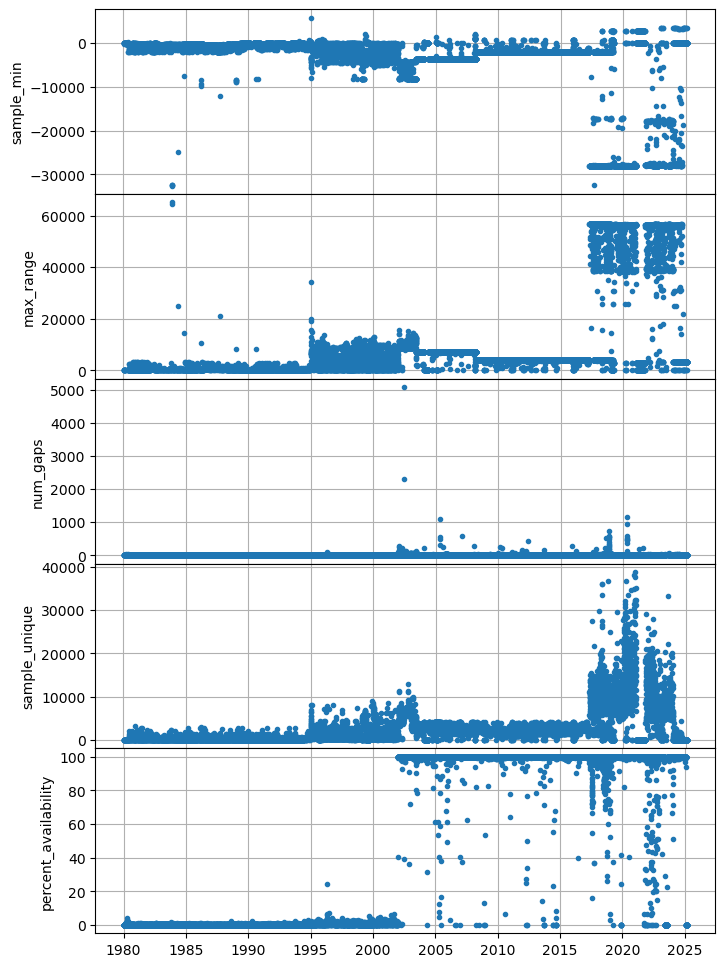

In [5]:
fig = plt.figure(figsize=(8,12))
gs = fig.add_gridspec(nrows=len(df_m.columns), hspace=0)

for _e, _c in enumerate(df_m.columns):
    ax = fig.add_subplot(gs[_e])
    ax.plot(df_m.index.get_level_values(0), df_m[_c].values, '.', label=_c)
    ax.set_ylabel(_c)
    ax.grid()


### Lots of gaps
Trying to bulk download gappy data from webservices can result in the entire request crashing.

If we can request with information on data availability (and which data seem to have meaning) then this job becomes easier.

Thankfully data availability is already documented by the NSF SAGE Facility FDSN Web Service!

# Running a FDSN Web Service query  

Use the custom-built `AvailabilityClient` class that follows the syntax of the  
related webservice: https://service.iris.edu/fdsnws/availability/1/  

For this example we'll keep looking at station UW.MBW.

In [6]:
# Initialize the client
aclient = AvailabilityClient()
# Run a data availability request for everything UW.MBW.*.EHZ has to offer
df_a = aclient.availability_request(sta='MBW',net='UW',cha='EHZ')
# Write to disk
df_a.to_csv(WFQC/'UW.MBW_Availability.csv', header=True, index=True)

In [7]:
# Take a look at the query results (and an option to read from disk for exercise expediancy)
try:
    display(df_a)
except NameError:
    df_m = pd.read_csv(WFQC/'UW.MBW_Availability.csv', index_col=[0], parse_dates=['Earliest','Latest'])
    display(df_a)

,Network,Station,Location,Channel,Quality,SampleRate,Earliest,Latest
0,UW,MBW,,EHZ,M,104.082,1980-01-11 21:40:16.543800+00:00,1980-01-11 21:41:08.185791+00:00
1,UW,MBW,,EHZ,M,104.084,1980-01-15 05:34:14.273800+00:00,1980-01-15 05:34:53.617023+00:00
2,UW,MBW,,EHZ,M,104.079,1980-01-17 05:39:19.142000+00:00,1980-01-17 05:40:03.406475+00:00
3,UW,MBW,,EHZ,M,104.082,1980-01-25 22:40:03.229300+00:00,1980-01-25 22:40:54.871291+00:00
4,UW,MBW,,EHZ,M,104.069,1980-01-27 23:41:48.775700+00:00,1980-01-27 23:42:15.825070+00:00
...,...,...,...,...,...,...,...,...
91602,UW,MBW,01,EHZ,M,100.000,2025-02-10 08:00:03+00:00,2025-02-10 08:00:03.990000+00:00
91603,UW,MBW,01,EHZ,M,100.000,2025-02-10 08:00:04.200000+00:00,2025-02-10 08:00:33.190000+00:00
91604,UW,MBW,01,EHZ,M,100.000,2025-02-10 08:00:45.400000+00:00,2025-02-11 08:00:01.390000+00:00
91605,UW,MBW,01,EHZ,M,100.000,2025-02-11 08:00:06.100000+00:00,2025-02-11 08:01:02.090000+00:00


### What is going on with the sampling rates?

Text(0, 0.5, 'Sampling Rate [sps]')

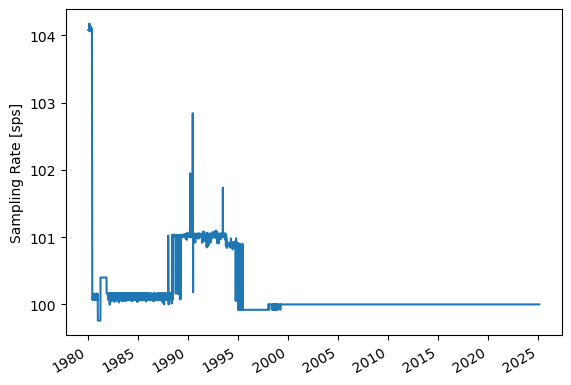

In [8]:
_series = pd.Series(df_a.SampleRate.values, index=df_a.Earliest.values)
ax = _series.plot()
ax.set_ylabel('Sampling Rate [sps]')

# Now lets' finally look at some data!

In [9]:
# IYKYK, or you're about to find out!
obspy_compat.plant()

In [10]:
# Get an obspy client for fetching waveforms
wclient = Client('IRIS')

In [11]:
# Subset available segments to a time window (currently uses pandas Timestamp objects)
_df_a = df_a[(df_a.Earliest >= pd.Timestamp('2023-02-19',tz='UTC')) & (df_a.Latest <= pd.Timestamp('2023-02-21',tz='UTC'))]
display(_df_a)

,Network,Station,Location,Channel,Quality,SampleRate,Earliest,Latest
86172,UW,MBW,01,EHZ,M,100.0,2023-02-19 02:18:28.300000+00:00,2023-02-19 02:19:31.290000+00:00
86173,UW,MBW,01,EHZ,M,100.0,2023-02-19 02:19:32.400000+00:00,2023-02-19 08:00:02.390000+00:00
86174,UW,MBW,01,EHZ,M,100.0,2023-02-19 08:00:06.300000+00:00,2023-02-19 12:01:02.290000+00:00
86175,UW,MBW,01,EHZ,M,100.0,2023-02-19 12:01:03.200000+00:00,2023-02-20 01:02:49.190000+00:00
86176,UW,MBW,01,EHZ,M,100.0,2023-02-20 01:02:50.100000+00:00,2023-02-20 02:45:06.090000+00:00
86177,UW,MBW,01,EHZ,M,100.0,2023-02-20 02:45:06.200000+00:00,2023-02-20 02:46:26.190000+00:00
86178,UW,MBW,01,EHZ,M,100.0,2023-02-20 02:46:27.200000+00:00,2023-02-20 08:00:01.190000+00:00
86179,UW,MBW,01,EHZ,M,100.0,2023-02-20 08:00:05.800000+00:00,2023-02-20 08:00:43.790000+00:00
86180,UW,MBW,01,EHZ,M,100.0,2023-02-20 08:00:43.900000+00:00,2023-02-20 11:02:01.890000+00:00
86181,UW,MBW,01,EHZ,M,100.0,2023-02-20 11:05:19.900000+00:00,2023-02-20 13:40:36.890000+00:00


In [12]:
# Compose a bulk request
bulk = []
for _, row in _df_a.iterrows():
    # Switch pandas Timestamp objects back to UTCDateTime objects for requests
    req = (row.Network, row.Station, row.Location, row.Channel, UTCDateTime(row.Earliest.timestamp()), UTCDateTime(row.Latest.timestamp()))
    bulk.append(req)
display(bulk)

[('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-19T02:18:28.300000Z,
  2023-02-19T02:19:31.290000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-19T02:19:32.400000Z,
  2023-02-19T08:00:02.390000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-19T08:00:06.300000Z,
  2023-02-19T12:01:02.290000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-19T12:01:03.200000Z,
  2023-02-20T01:02:49.190000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-20T01:02:50.100000Z,
  2023-02-20T02:45:06.090000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-20T02:45:06.200000Z,
  2023-02-20T02:46:26.190000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-20T02:46:27.200000Z,
  2023-02-20T08:00:01.190000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-20T08:00:05.800000Z,
  2023-02-20T08:00:43.790000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-20T08:00:43.900000Z,
  2023-02-20T11:02:01.890000Z),
 ('UW',
  'MBW',
  '01',
  'EHZ',
  2023-02-20T11:05:19.900000Z,
  2023-02-20T13:40:36.890000Z),
 ('UW',
  'MBW',
  '01',
  'EH

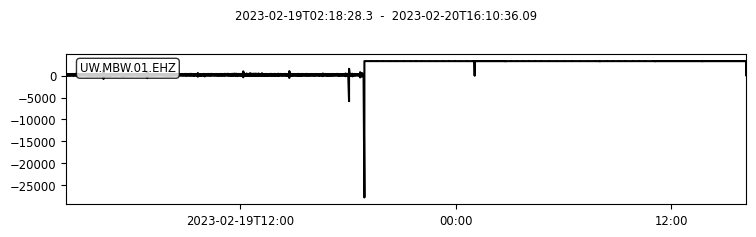

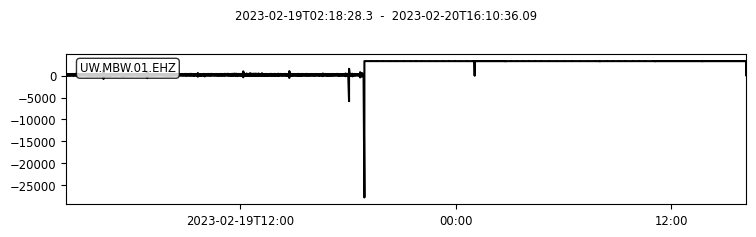

In [13]:
# Run bulk request
st = wclient.get_waveforms_bulk(bulk)
st.plot()

## It looks like we have continuous data...
### Are they continuous?
### Where do they stop being useful?
### What does this mean for your workflow?

## Let's take an interactive look at our waveform data

In [14]:
# Let's take an interactive look at our waveforms
(exit_code, snuffler_pile) = st.snuffle()

qt.qpa.fonts: Populating font family aliases took 54 ms. Replace uses of missing font family ".AppleSystemUIFont" with one that exists to avoid this cost. 
